In [1]:
libraries = c("dplyr", "tidyverse", "magrittr", "scales", "ggplot2")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

theme_set(theme_bw())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [28]:
###0. data processing
#load data
raw_global_FoI_data <- read.csv("result_counter.csv")
raw_global_FoI_data$date <- as.Date(raw_global_FoI_data$date)
raw_global_FoI_data$date_import <- as.Date(raw_global_FoI_data$date_import)

global_FoI_data <- raw_global_FoI_data %>%
  filter(censoring==0) #%>%
  #filter(F_i>0)


vis_data <- global_FoI_data %>%
filter(!(location %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                         "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                         "United Kingdom"))) %>%
#   filter(sub_region %in% c("Western Europe","Northern America"))
  filter(region %in% c("Europe"))
  #filter(location %in% c(selected_location2))#c(selected_location, sampled_location))



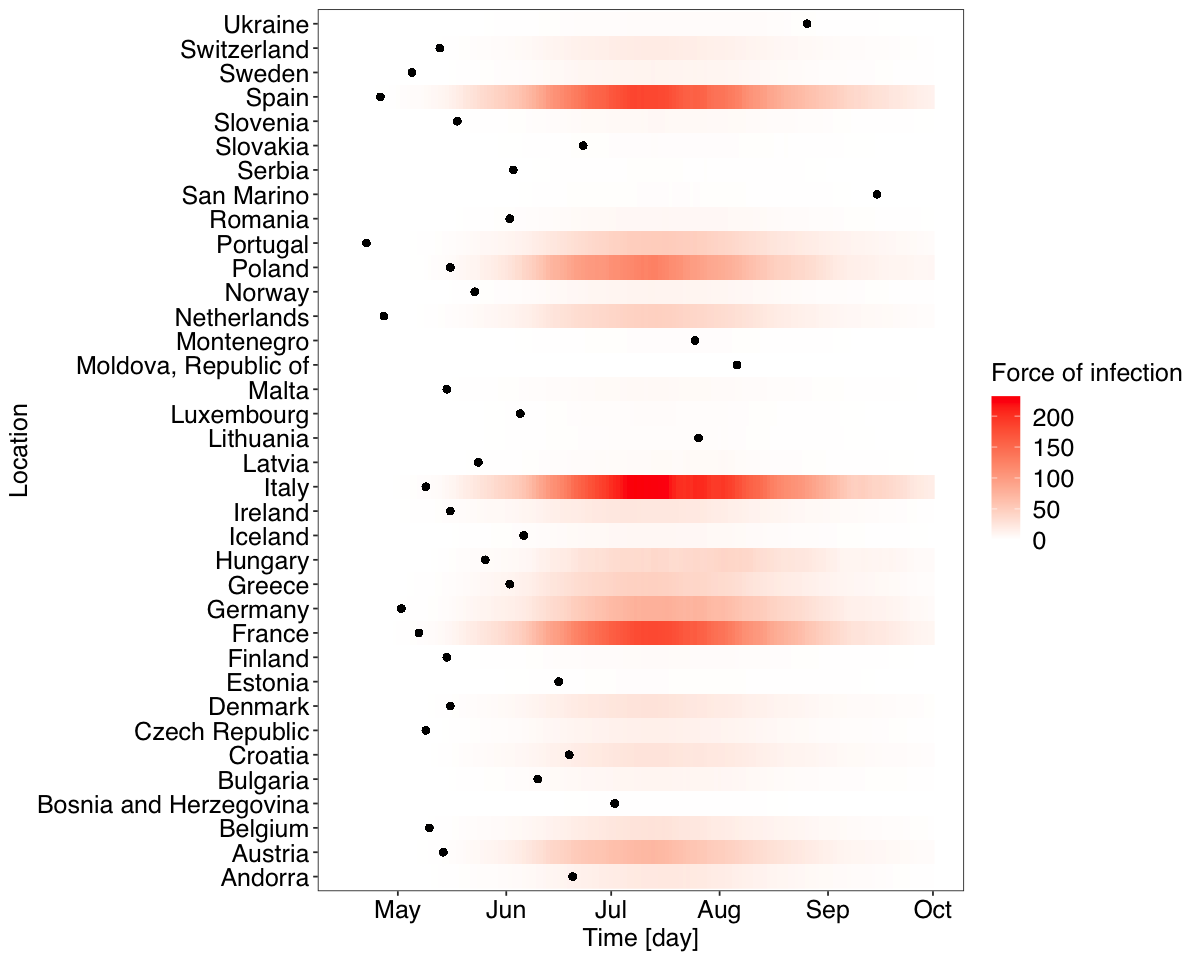

In [29]:
###1. FoI over time
theme_set(theme_bw())

options(repr.plot.width=10,repr.plot.height=8)
ggplot(data = vis_data,
       mapping = aes(x = date, y =location)) +
  geom_raster(aes(fill=F_i)) +
  scale_fill_gradient(low="white", high="red", name="Force of infection") +
  geom_point(mapping = aes(x=date_import, y=location))+#, color=region))+
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.title = element_text(size = 15),
        legend.text = element_text(size = 15),
        plot.title = element_text(size=18, family="sans",color="black")) +
  labs(x="Time [day]", y="Location")

# ggsave("EU_FoI.png", width = 10, height = 8)

Warning message:
“Transformation introduced infinite values in continuous y-axis”


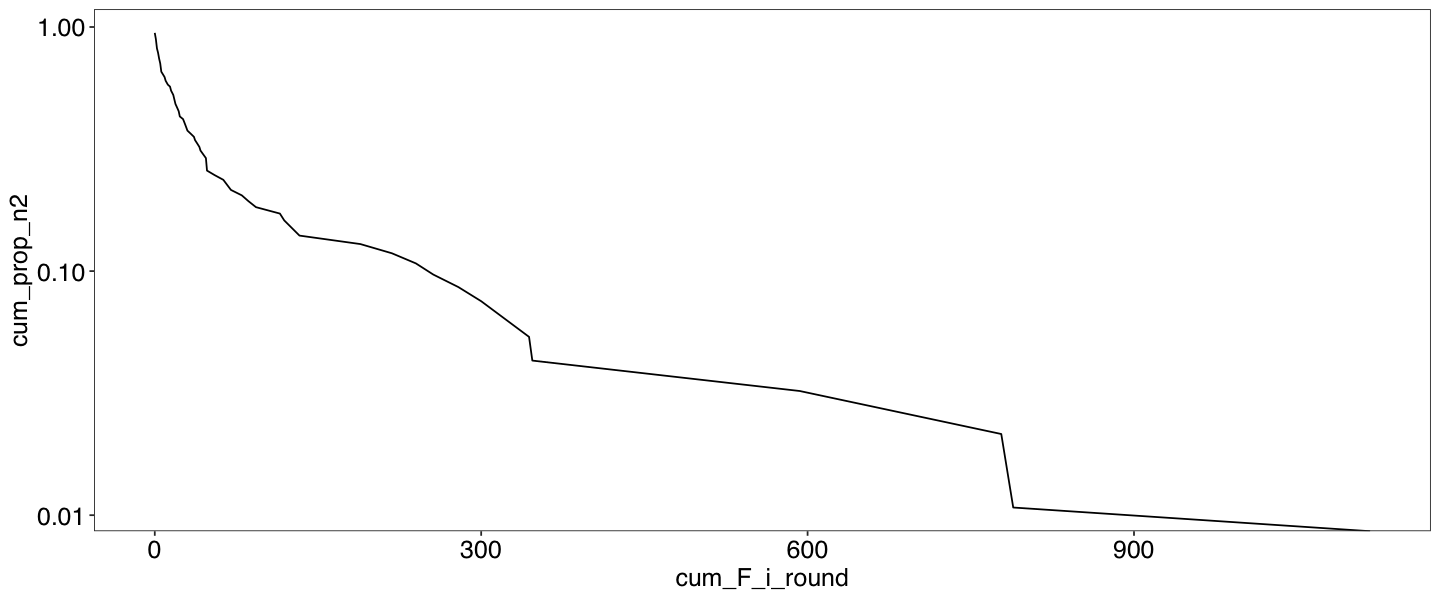

In [31]:
temp_round %>% mutate(prop_n = n/sum(temp_round$n)) %>% 
mutate(cum_prop_n=cumsum(prop_n), cum_prop_n2=1-cum_prop_n) -> temp_figure

temp_figure %>%
ggplot(aes(x=cum_F_i_round, y=cum_prop_n2)) +
geom_line() +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      axis.title = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black")) +  
scale_y_continuous(trans='log10')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


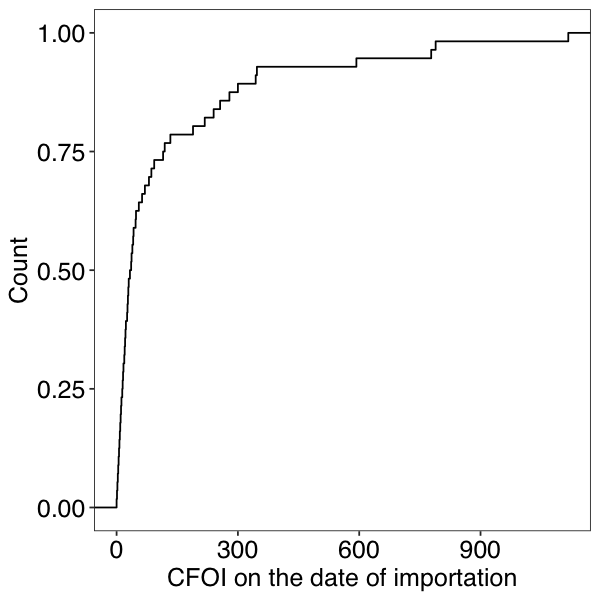

[1] 58.39579

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


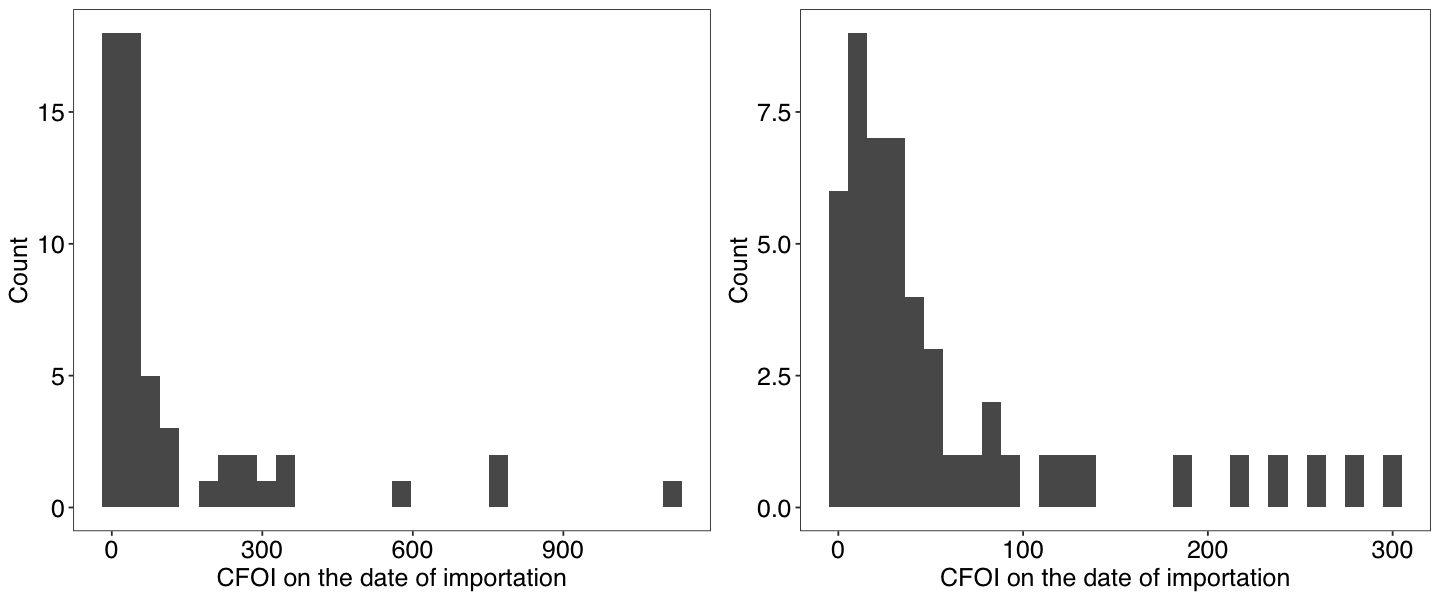

In [30]:
raw_global_FoI_data %>% filter(censoring==0) %>% dplyr::select(location, date, date_import, F_i) %>%
arrange(location, date) %>% group_by(location) %>% mutate(cum_F_i=cumsum(F_i)) %>% 
filter(!(location %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                         "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                         "United Kingdom"))) -> cum_global_FoI_data

## distribution of the CFOI at the date of importation
cum_global_FoI_data %>% ungroup() %>% mutate(diff=date_import-date) %>% filter(diff==0) -> temp
temp %>% mutate(cum_F_i_round=round(cum_F_i)) %>% group_by(cum_F_i_round) %>% summarise(n=n()) -> temp_round


options(repr.plot.width=5,repr.plot.height=5)
temp_round %>% 
ggplot(aes(x=cum_F_i_round, y=n)) + geom_step(stat='ecdf') +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      axis.title = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black")) +  
labs(x="CFOI on the date of importation", y="Count")

options(repr.plot.width=5,repr.plot.height=5)
temp_round %>% 
ggplot(aes(x=cum_F_i_round)) + geom_histogram() +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      axis.title = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black")) +  
labs(x="CFOI on the date of importation", y="Count") -> Fig1


options(repr.plot.width=5,repr.plot.height=5)
temp_round %>% filter(cum_F_i_round <= 300) %>%
ggplot(aes(x=cum_F_i_round)) + geom_histogram() +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      axis.title = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black")) + 
labs(x="CFOI on the date of importation", y="Count") -> Fig2

options(repr.plot.width=12,repr.plot.height=5)
library(ggpubr)
ggarrange(Fig1, Fig2, ncol = 2, nrow = 1)
ggsave("dist_counter.png", width = 12, height = 5)

## fitting with the exponential distribution
temp_df <- rep(temp_round$cum_F_i_round, temp_round$n)
llk <- function(param){-sum(dexp(temp_df, param, log=TRUE))}
estimated <- optim(0.01, fn=llk, method='Brent', lower=c(0), upper=c(10), control = list(maxit=100000, trace=0))
(cutoff_value <- log(2)/estimated$par)

cum_global_FoI_data %>% group_by(location) %>% summarise(import=date_import) %>% 
distinct() %>% mutate(cutoff=cutoff_value) -> df_import

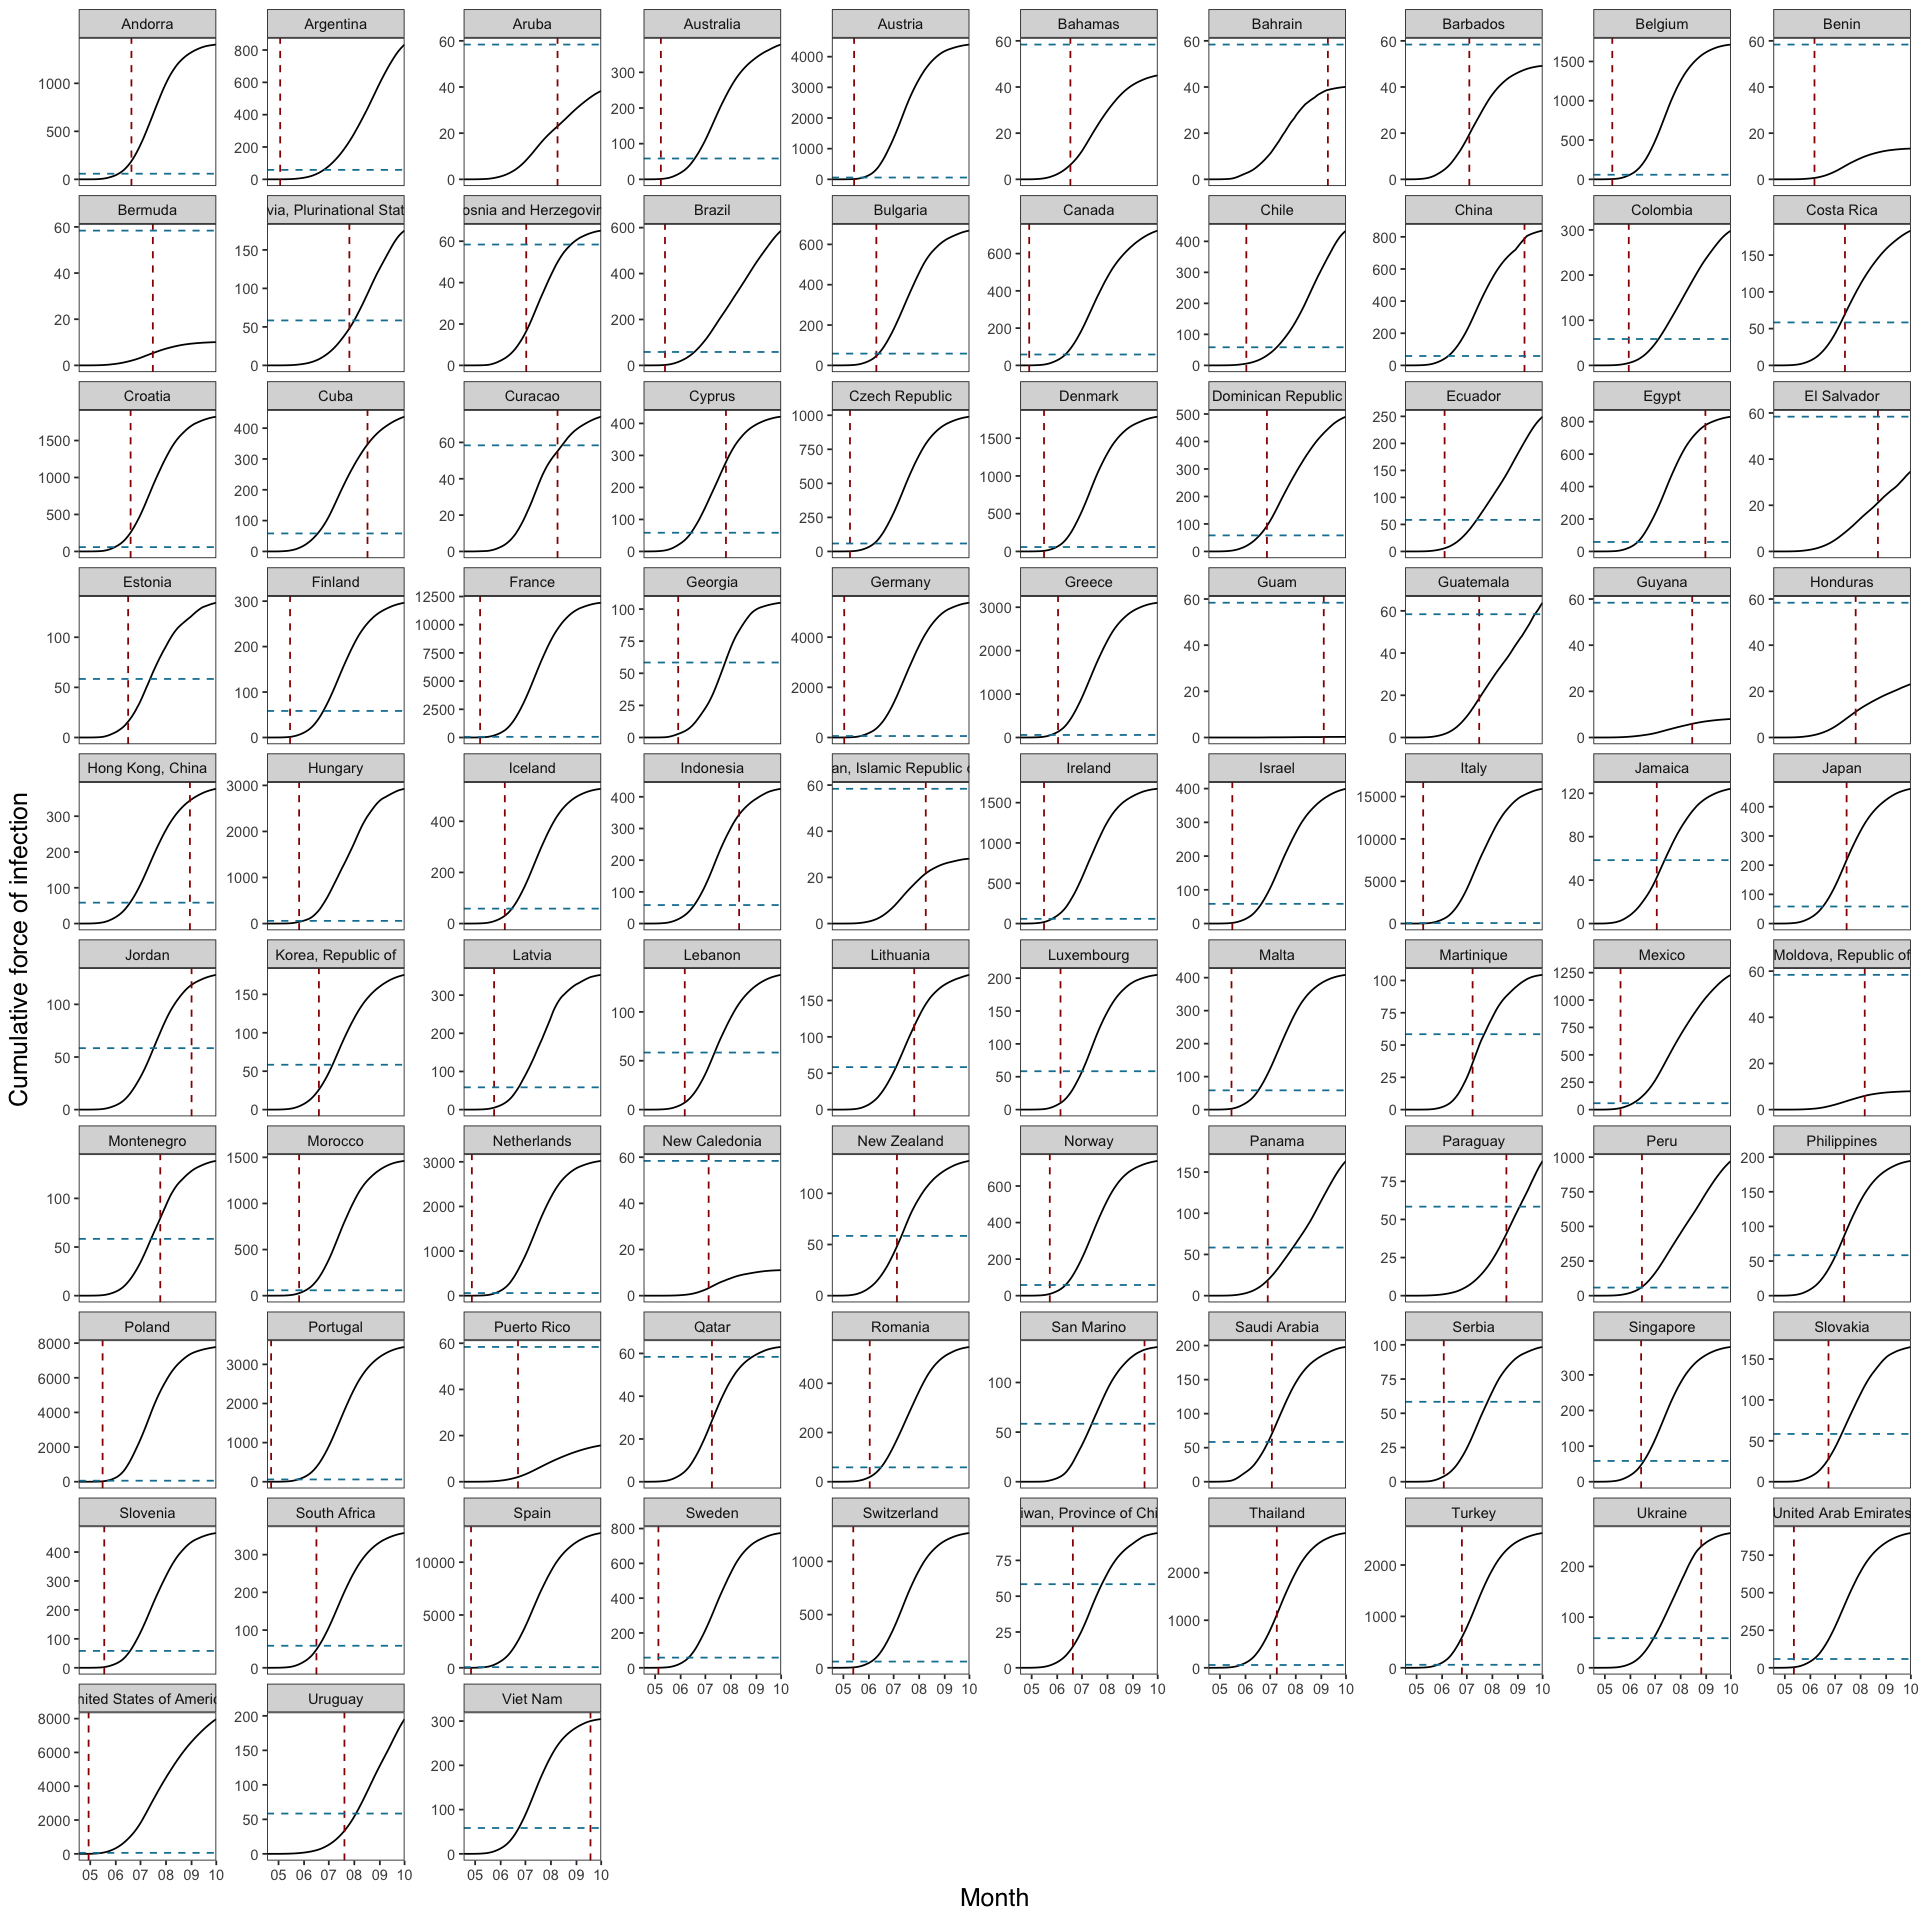

In [32]:
options(repr.plot.width=16,repr.plot.height=16)

cum_global_FoI_data %>%
ggplot(aes(x = date, y = cum_F_i)) + 
geom_line() +
geom_vline(data=df_import, aes(xintercept=import), linetype="dashed", color="#990000") +
geom_hline(data=df_import, aes(yintercept=cutoff), linetype="dashed", color = "#1380A1") +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
       axis.title = element_text(size=15, family="sans",color="black")) + 
scale_x_date(date_breaks = "1 months", date_labels="%m", expand = c(0, 0)) +
labs(x="Month", y="Cumulative force of infection") +
facet_wrap(~location, scales = "free_y")

ggsave("cum_FoI_counter.png", width = 16, height = 16)